In [10]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier  # Import XGBoost classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pprint 



In [2]:
pp = pprint.PrettyPrinter(indent=4)

In [11]:

data = pd.read_csv('./DATA/data.csv')

In [19]:
# Momentum Indicators
data['ema_diff_9'] = data['close'] - data['9_ema']
data['ema_diff_21'] = data['close'] - data['21_ema']
data['ema_diff_50'] = data['close'] - data['50_ema']
data['ema_diff_200'] = data['close'] - data['200_ema']
data['roc_9'] = data['close'].pct_change(periods=9)
data['roc_21'] = data['close'].pct_change(periods=21)
# Volatility Indicators
data['atr_14'] = data['high'].pct_change().rolling(14).apply(lambda x: np.sum(np.abs(x))).rolling(14).mean()
bb = ta.bbands(data['close'], length=20, scalar=2)
bb_column_names = bb.columns

# Check the column names
print(bb_column_names)

# Assign the correct column names
data['bb_upper'] = bb[bb_column_names[0]]
data['bb_middle'] = bb[bb_column_names[1]]
data['bb_lower'] = bb[bb_column_names[2]]


# On-chain Indicators
data['mvrv_zscore'] = (data['mvrv'] - data['mvrv'].rolling(30).mean()) / data['mvrv'].rolling(30).std()
data['nupl_zscore'] = (data['nupl'] - data['nupl'].rolling(30).mean()) / data['nupl'].rolling(30).std()


# Momentum Indicators for Fear and Greed Index
data['fg_roc_9'] = data['Fear_and_Greed_Index'].pct_change(periods=9)
data['fg_roc_21'] = data['Fear_and_Greed_Index'].pct_change(periods=21)
data['fg_ema_9'] = data['Fear_and_Greed_Index'].ewm(span=9, adjust=False).mean()
data['fg_ema_21'] = data['Fear_and_Greed_Index'].ewm(span=21, adjust=False).mean()

# Volatility Indicators for Fear and Greed Index
data['fg_atr_14'] = data['Fear_and_Greed_Index'].pct_change().rolling(14).apply(lambda x: np.sum(np.abs(x))).rolling(14).mean()
bb = ta.bbands(data['Fear_and_Greed_Index'], length=20, scalar=2)
bb_column_names = bb.columns

# Check the column names
print(bb_column_names)

# Assign the correct column names
data['bb_upper'] = bb[bb_column_names[0]]
data['bb_middle'] = bb[bb_column_names[1]]
data['bb_lower'] = bb[bb_column_names[2]]


# Fear and Greed Index Extremes
data['fg_extreme_fear'] = (data['Fear_and_Greed_Index'] < 20).astype(int)
data['fg_extreme_greed'] = (data['Fear_and_Greed_Index'] > 80).astype(int)

# Fear and Greed Index Signals
data['fg_buy_signal'] = np.where((data['Fear_and_Greed_Index'].shift(1) < 25) & (data['Fear_and_Greed_Index'] >= 25), 1, 0)
data['fg_sell_signal'] = np.where((data['Fear_and_Greed_Index'].shift(1) > 75) & (data['Fear_and_Greed_Index'] <= 75), 1, 0)

Index(['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0'], dtype='object')
Index(['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0'], dtype='object')


In [20]:
# Assuming 'data' is your DataFrame and 'signal' is the target variable
X = data.drop(['signal', 'datetime'], axis=1)  # Exclude 'datetime' for model training
y = data['signal'].map({'buy': 0, 'sell': 1, 'none': 2}).astype(int)  # Encoding signals
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
# Define class weights
class_weights_custom = {0: 10, 1: 10, 2: 1}

xgb_classifier = XGBClassifier()

# Initialize XGBoost classifier with class weights
classes_weights = class_weight.compute_sample_weight(
    class_weight=class_weights_custom,
    y=y_train
)
# Train the classifier
xgb_classifier.fit(X_train_scaled
                   , y_train
                   , sample_weight=classes_weights
                   )

# Predict signals on the test set
y_pred = xgb_classifier.predict(X_test_scaled)

#Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate class accuracy, f1 score, and confusion matrix
class_accuracy = classification_report(y_test, y_pred, output_dict=True)
confusion_mat = confusion_matrix(y_test, y_pred)

# Print the results
print("Class Accuracy:")
pp.pprint(class_accuracy)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.8235294117647058
Class Accuracy:
{   '0': {   'f1-score': 0.2758620689655173,
             'precision': 0.4444444444444444,
             'recall': 0.2,
             'support': 20.0},
    '1': {   'f1-score': 0.5714285714285714,
             'precision': 0.8888888888888888,
             'recall': 0.42105263157894735,
             'support': 19.0},
    '2': {   'f1-score': 0.8958990536277601,
             'precision': 0.8402366863905325,
             'recall': 0.9594594594594594,
             'support': 148.0},
    'accuracy': 0.8235294117647058,
    'macro avg': {   'f1-score': 0.5810632313406163,
                     'precision': 0.7245233399079553,
                     'recall': 0.5268373636794689,
                     'support': 187.0},
    'weighted avg': {   'f1-score': 0.7966173485206509,
                        'precision': 0.8028492372383775,
                        'recall': 0.8235294117647058,
                        'support': 187.0}}
Confusion Matrix:
[[  4   0  

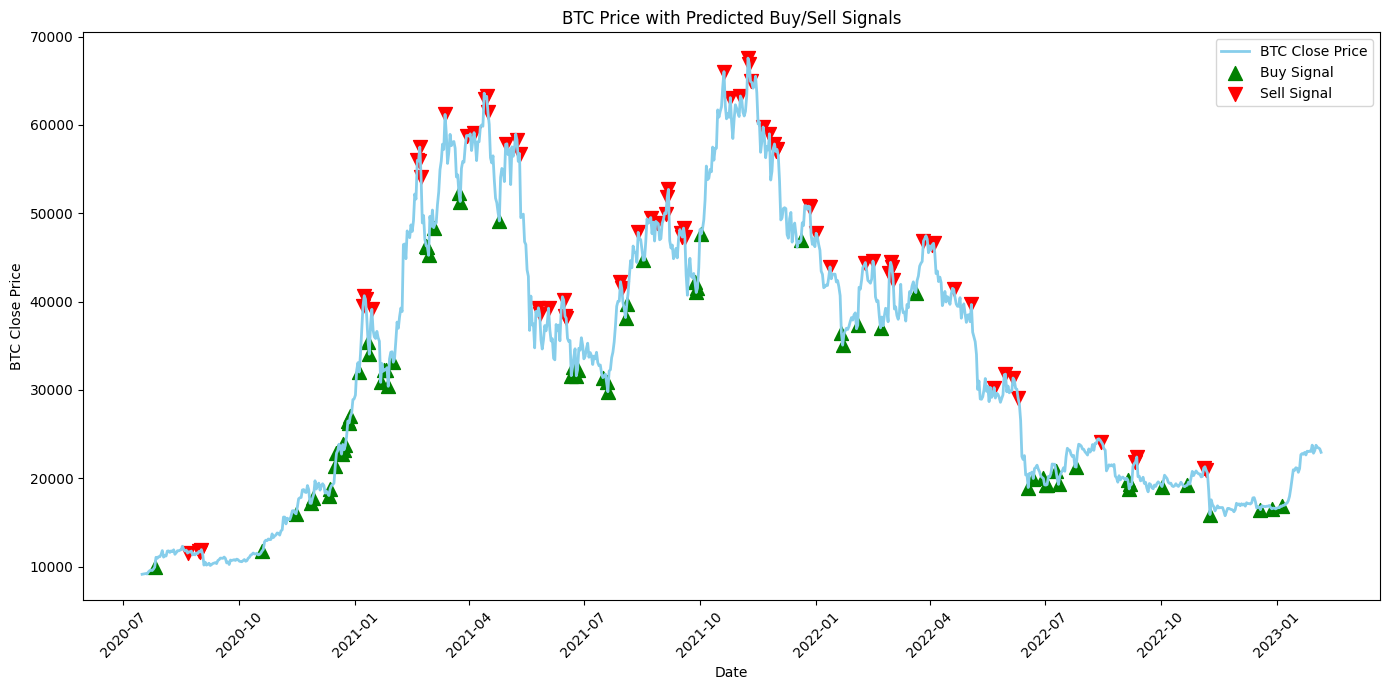

In [26]:

import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime is in the correct format
data['datetime'] = pd.to_datetime(data['datetime'])
X_scaled = scaler.fit_transform(X)
data['predicted_signal'] =  xgb_classifier.predict(X_scaled)
plt.figure(figsize=(14, 7))
plt.plot(data['datetime'], data['close'], label='BTC Close Price', color='skyblue', linewidth=2)

# Adjust the conditions to match the labels
# Highlight buy signals
buy_signals = data[data['predicted_signal'] == 0]  # Assuming 0 represents 'buy'
plt.scatter(buy_signals['datetime'], buy_signals['close'], label='Buy Signal', marker='^', color='green', alpha=1, s=100)

# Highlight sell signals
sell_signals = data[data['predicted_signal'] == 1]  # Assuming 1 represents 'sell'
plt.scatter(sell_signals['datetime'], sell_signals['close'], label='Sell Signal', marker='v', color='red', alpha=1, s=100)

plt.title('BTC Price with Predicted Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("AfterClassBalancing")
plt.show()